In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
import datetime as dt

pd.options.mode.chained_assignment = None  # default='warn'

/Users/fqian/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from sklearn import metrics
from sklearn import svm

## 1. Data Cleaning and Feature Engineering

#### 1.1 First clean: only take the useful columns

In [3]:
round3 = pd.read_json("round3_merged.json")
round2 = pd.read_json("round2_merged.json")
round1 = pd.read_json("round1_merged.json")

In [5]:
round3_clean = round3[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount_agreed", "percent_agreed",
                       "calendars", "price_requested"]]
round2_clean = round2[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount_agreed", "percent_agreed",
                       "calendars", "price_requested"]]
round1_clean = round1[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "availability", "price", "discount",
                       "calendars", "price_requested"]]

print "Number of observations in round 3: ", len(round3_clean)
print "Number of observations in round 2: ", len(round2_clean)
print "Number of observations in round 1: ", len(round1_clean)

# round3_clean.reset_index(drop=True).head()

Number of observations in round 3:  288
Number of observations in round 2:  226
Number of observations in round 1:  194


In [6]:
round1_clean = round1_clean.rename(columns = {"availability":"decision", "price":"price_agreed", "discount":"percent_agreed"})
# round1_clean.head()

In [7]:
round1_clean = round1_clean.rename(columns = {"availability":"decision", "price":"price_agreed", "discount":"percent_agreed"})
round1_clean["percent_agreed"] = [np.nan if val==None else float(val.strip("%"))/100. for val in  round1_clean.percent_agreed.values]

combined = pd.concat([round1_clean, round2_clean, round3_clean], keys=["round1", "round2", "round3"], ignore_index=False)
combined["source"] = combined.index.labels[0]+1
combined = combined.reset_index(drop=True)

In [8]:
# combined.head()

In [9]:
combined.isnull().sum()

bucket_name                    0
calendars                      0
decision                       0
discount_agreed              705
discount_asked                 0
host_acceptance_rate          56
host_id                        0
host_response_rate            20
host_total_listings_count      0
id                             0
instant_bookable               0
nightly_price                  0
percent_agreed               703
price_agreed                 573
price_requested              283
room_type                      0
source                         0
dtype: int64

#### 1.2 Add useful independent variables

Add variables from the calendars:
* median price
* standard deviation （normalized, using the median price)

In [10]:
calendar_price =  np.array([(np.median(calendar["price_USD"].values()), np.std(calendar["price_USD"].values()), np.max(calendar["price_USD"].values())) 
                            for calendar in combined["calendars"].values])
calendar_median_price = calendar_price[:,0]
calendar_price_std = calendar_price[:,1]
calendar_price_high = calendar_price[:,2]

combined["price_median"]=calendar_median_price
combined["price_std"]=calendar_price_std/calendar_median_price
combined["orig_percent_off"]=1-combined["nightly_price"]/calendar_price_high

* 1-month occupancy rate

In [11]:
key_1m = map(str, range(30))
calendar_occupancy = [np.mean([calendar["availability"][key] for key in key_1m]) for calendar in combined["calendars"].values]

combined["occupancy_1m"]=calendar_occupancy

Convert string variables to numeric:
* whether room will be shared
* whether instant booking is turned on
* the response rate of the host (contains nans)

In [12]:
shared = combined["room_type"].values
combined["shared"] = [x!="Entire home/apt" for x in shared]
# shared_binary

instant = combined["instant_bookable"].values
combined["instant"] = [x=="t" for x in shared]
# instant_binary

In [13]:
response_imputer = Imputer(copy=True, missing_values='NaN', strategy='mean', axis=1)
response_num = np.array([float(response_rate.strip('%'))/100 for response_rate in combined["host_response_rate"].fillna(value="-100%").values])
response_num = np.array([np.nan if x < 0 else x for x in response_num])
# response_imputer.fit(response_num)
response_imputed = response_imputer.fit_transform(response_num)[0]

# print len(response_imputed)
combined["response_rate"] = response_imputed

/Users/fqian/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


#### 1.3 Add indicators for the buckets

Construct 11 variables: 3 types of orphans, 2 types of advances, and 3x2=6 types of interactions

In [14]:
opening_attr = combined["bucket_name"].values
# orphan = []
# advance = []
N = len(opening_attr)
orp_1 = np.zeros(N)
orp_2 = np.zeros(N)
orp_3 = np.zeros(N)
adv_1 = np.zeros(N)
adv_2 = np.zeros(N)

for (i,x) in enumerate(opening_attr):
    if x == "days1_weeks1":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days1_weeks2":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days1_weeksM":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "days2_weeks1":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days2_weeks2":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days2_weeksM":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "days3_weeks1":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days3_weeks2":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days3_weeksM":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "daysM_weeks1":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "daysM_weeks2":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "daysM_weeksM":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
        
combined["orp_1"]=orp_1
combined["orp_2"]=orp_2
combined["orp_3"]=orp_3
combined["adv_1"]=adv_1
combined["adv_2"]=adv_2

In [15]:
combined["orp_1, adv_1"] = combined["orp_1"]*combined["adv_1"]
combined["orp_1, adv_2"] = combined["orp_1"]*combined["adv_2"]
combined["orp_2, adv_1"] = combined["orp_2"]*combined["adv_1"]
combined["orp_2, adv_2"] = combined["orp_2"]*combined["adv_2"]
combined["orp_3, adv_1"] = combined["orp_3"]*combined["adv_1"]
combined["orp_3, adv_2"] = combined["orp_3"]*combined["adv_2"]

In [16]:
# combined.columns

#### 1.4 Process the decision variables:

Calculate the percentage of the discount agreed:

In [17]:
combined.groupby("decision")["id"].count()/len(combined)

decision
-1    0.471751
 0    0.316384
 1    0.211864
Name: id, dtype: float64

In [18]:
orig_price = combined["nightly_price"]
price_agreed_percent = (np.nan_to_num(combined["price_agreed"])/orig_price)
discount_agreed1 = [0 if (d>=1 or d==0) else 1-d for d in price_agreed_percent]
discount_agreed2 = np.nan_to_num(combined["discount_agreed"]/orig_price)
discount_agreed3 = np.nan_to_num(combined["percent_agreed"])

discount_obtained = np.max([discount_agreed1, discount_agreed2, discount_agreed3], axis=0)
# print discount_agreed

combined["discount_obtained"] = discount_obtained

#### 1.5 Again, only keep the useful columns

In [19]:
# combined.columns

In [20]:
combined_clean = combined[["host_total_listings_count", "response_rate", "instant", "shared", 
                               "price_median", "price_std", "occupancy_1m",
                               "orp_1", "orp_2", "orp_3", "adv_1", "adv_2", 
                               "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2",
                               "orig_percent_off", "discount_asked", "decision", "discount_obtained", "source"]]

In [21]:
combined_clean.head()

,host_total_listings_count,response_rate,instant,shared,price_median,price_std,occupancy_1m,orp_1,orp_2,orp_3,...,"orp_1, adv_2","orp_2, adv_1","orp_2, adv_2","orp_3, adv_1","orp_3, adv_2",orig_percent_off,discount_asked,decision,discount_obtained,source
0,1,1,False,True,45,0.090351,0.433333,0,0,0,...,0,0,0,0,0,0.055556,0.7,0,0,1
1,1,1,False,False,106,0.144629,0.700000,1,0,0,...,0,0,0,0,0,0.000000,0.7,-1,0,1
2,5,1,False,True,46,0.021650,0.366667,0,0,1,...,0,0,0,1,0,0.108696,0.9,-1,0,1
3,2,1,False,False,120,0.095207,0.500000,0,1,0,...,0,1,0,0,0,0.246269,0.7,-1,0,1
4,1,1,False,True,65,0.000000,0.933333,0,0,0,...,0,0,0,0,0,0.000000,0.6,0,0,1


## 2. Construct training samples

For studying whether hosts are negotiable, we consider 2 types of acceptance rate:

* Accepted / (Accepted + Rejected)
* Accepted / (Accepted + Rejected + No Response)

For studying how much discounts each host is willing to give, we only include hosts that gave a discount percentage.

And, for each study, the discount asked may or may not be an important factor- we will see.

In [26]:
mask_available = combined_clean["decision"] != -1 
mask_agreed = combined_clean["discount_obtained"] != 0
mask_no_source1 = combined_clean["source"] != 1

combined_available = combined_clean[mask_available]
combined_agreed = combined_clean[mask_agreed * mask_no_source1]

cal_param_1 = ["orp_1", "orp_2", "orp_3", "adv_1", "adv_2"]
cal_param_2 = ["orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2"]
host_param = ["orig_percent_off", "host_total_listings_count", "response_rate", "instant", "shared",  "price_median", "price_std", "occupancy_1m"]
param_rf = cal_param_1 + host_param
param_lr = cal_param_1 + cal_param_2 + host_param

X_responded_rf = combined_available[param_rf].values
X_responded_lr = combined_available[param_lr].values
Y_responded = combined_available["decision"].values

X_all_rf = combined_clean[param_rf].values
X_all_lr = combined_clean[param_lr].values
Y_all = combined_clean["decision"].values 
Y_all = np.max(zip(Y_all,np.zeros(len(Y_all))), axis=1)

X_discount_rf = combined_agreed[param_rf].values
X_discount_lr = combined_agreed[param_lr].values
Y_discount = combined_agreed["discount_obtained"].values

In [23]:
# combined_agreed.head()

In [24]:
# print X_willing.shape
# print X_willing_noda.shape
# print Y_willing.shape

# print X_willing_all.shape
# print X_willing_all_noda.shape
# print Y_willing_all.shape

# print X_discount.shape
# print X_discount_noda.shape
# print Y_discount.shape

In [25]:
param_label_rf = ["1-day orphan", "2-day orphan", "3-day_orphan", "Within 1 week", "1-2 weeks in advance", 
               "Percent off highest price", "Host listing count", "Host response rate", 
               "Instant bookable", "Space shared with host", "Usual price", "Price variation", "1-month occupancy"]

## 3. Model Fitting and Prediction


### 3.1 Acceptance rate as Accepted / (Accepted + Rejected)

In [41]:
clf_rf = RandomForestClassifier(n_estimators=1000, 
                        max_features=int(np.sqrt(X_willing_noda.shape[1])), 
                        max_depth=None,
                        min_samples_split=1)

clf_rf.fit(X_all_rf,Y_all)
Y_all_pred = clf_rf.predict(X_all_rf)
Y_all_pred_prob = clf_rf.predict_proba(X_all_rf)[:,1]

In [45]:
roc_rf = metrics.roc_curve(Y_all, Y_all_pred_prob)
auc_rf = metrics.roc_auc_score(Y_all, Y_all_pred_prob)
print auc_rf

1.0


In [44]:
# Precision
precision_rf = metrics.precision_score(Y_all, Y_all_pred)
print precision_rf

1.0


In [29]:
def model_fitting(X_rf, X_lr, Y, label=None, fold=10):
    clf_rf = RandomForestClassifier(n_estimators=1000, 
                            max_features=int(np.sqrt(X_willing_noda.shape[1])), 
                            max_depth=None,
                            min_samples_split=1)
    
    clf_rf.fit(X_rf,Y)
    
    cv_scores = -cross_val_score(clf, X, Y, scoring='mean_squared_error', cv=fold)
    print "Average Cross Validation Accuracy: \n", 1-np.mean(cv_scores)
    print "Cross Validation Accuracies by Fold: \n", 1 - np.array(cv_scores)
    

    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::1]
    param_label_sorted = [label[ind] for ind in indices]

    # Print the feature ranking
    # print("Feature ranking:")

    # for f in range(X.shape[1]):
        # print("%d. %s (feature %d, importance: %f)" % (f + 1, param_label[indices[f]], indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure(figsize=(16,10))
    plt.title("Feature Importance", fontsize=30)
    plt.barh(range(X.shape[1]), importances[indices],color="green", align="center")
    # plt.axvline(x=0.05, color="red", ls="--")
    plt.yticks(range(X.shape[1]), param_label_sorted,  fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylim([-1, X.shape[1]])
    plt.xlim([0,0.25])
    plt.grid(False)
    plt.show()
    
    if name=="lr":
        sign = ["(-)" if s<0 else "(+)" for s in np.sign(np.ravel(clf.coef_))]
        print "Coefficients: \n"
        return [x[0] + x[1] for x in zip(param_label_noda, sign)]

#### Random Forest: Accuracy and Feature Importance

Ensemble methods: http://scikit-learn.org/stable/modules/ensemble.html
* random sample (with replacement)
* random feature
* average probablistic prediction

Average Cross Validation Accuracy: 
0.582574679943
Cross Validation Accuracies by Fold: 
[ 0.57894737  0.63157895  0.55263158  0.68421053  0.51351351  0.48648649
  0.62162162  0.59459459  0.64864865  0.51351351]


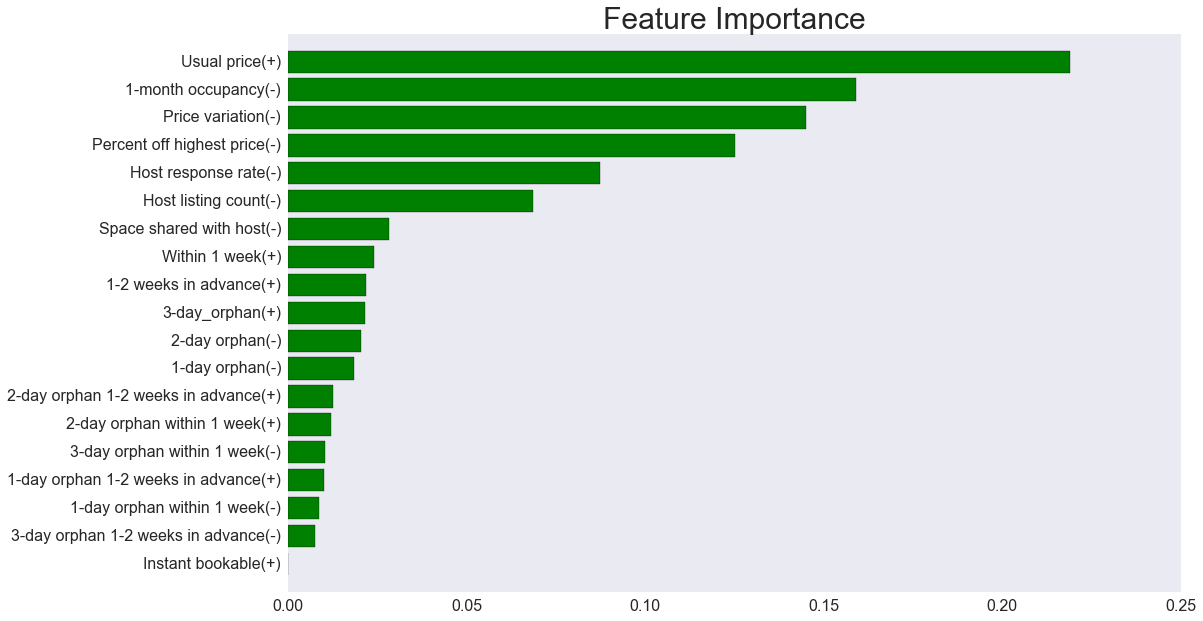

In [157]:
rf = RandomForestClassifier(n_estimators=1000, 
                            max_features=int(np.sqrt(X_willing_noda.shape[1])), 
                            max_depth=None,
                            min_samples_split=1)
model_fitting("rf", rf, X_willing_noda, Y_willing, label=label)

#### Logistic Regression: Sign of the Feature

In [156]:
lr = LogisticRegression()
label = model_fitting("lr", lr, X_willing_noda, Y_willing)

Average Cross Validation Accuracy: 
0.606685633001
Cross Validation Accuracies by Fold: 
[ 0.57894737  0.63157895  0.57894737  0.73684211  0.59459459  0.56756757
  0.62162162  0.56756757  0.59459459  0.59459459]
Coefficients: 



#### SVM: better prediction?

In [28]:
svm = svm.SVC()
model_fitting("svm", svm, X_willing_noda, Y_willing)

Average Cross Validation Accuracy: 
0.62012802276
Cross Validation Accuracies by Fold: 
[ 0.68421053  0.57894737  0.63157895  0.65789474  0.56756757  0.59459459
  0.64864865  0.7027027   0.45945946  0.67567568]


#### Let's be crazy: 8 classifiers together

In [38]:
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=None),
    RandomForestClassifier(max_depth=None, n_estimators=1000, max_features=5),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

print "Average Cross Validation Accuracy:"
for name, clf in zip(names, classifiers):
    clf.fit(X_willing_noda, Y_willing)
    cv_scores = -cross_val_score(clf, X_willing_noda, Y_willing, scoring='mean_squared_error', cv=10)

    print "%s: "%name, 1-np.mean(cv_scores)

Average Cross Validation Accuracy:
Nearest Neighbors:  0.612375533428
Linear SVM:  0.596088193457
RBF SVM:  0.598790896159
Decision Tree:  0.518278805121
Random Forest:  0.582361308677
AdaBoost:  0.585419630156
Naive Bayes:  0.550568990043
Linear Discriminant Analysis:  0.606685633001
Quadratic Discriminant Analysis:  0.561166429587


/Users/fqian/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/fqian/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### 3.2 Accepted / (Accepted + Rejected + No Response)

In [30]:
lr_all = LogisticRegression()
model_fitting("lr", lr_all, X_willing_all_noda, Y_willing_all)

Average Cross Validation Accuracy: 
0.786720321932
Cross Validation Accuracies by Fold: 
[ 0.78873239  0.78873239  0.78873239  0.78873239  0.78873239  0.78873239
  0.78873239  0.77464789  0.78571429  0.78571429]
Coefficients: 



['1-day orphan(-)',
 '2-day orphan(-)',
 '3-day_orphan(+)',
 'Within 1 week(-)',
 '1-2 weeks in advance(+)',
 '1-day orphan within 1 week(-)',
 '1-day orphan 1-2 weeks in advance(+)',
 '2-day orphan within 1 week(+)',
 '2-day orphan 1-2 weeks in advance(+)',
 '3-day orphan within 1 week(-)',
 '3-day orphan 1-2 weeks in advance(-)',
 'Percent off highest price(+)',
 'Host listing count(-)',
 'Host response rate(+)',
 'Instant bookable(+)',
 'Space shared with host(-)',
 'Usual price(+)',
 'Price variation(-)',
 '1-month occupancy(-)']

Average Cross Validation Accuracy: 
0.769758551308
Cross Validation Accuracies by Fold: 
[ 0.78873239  0.77464789  0.77464789  0.77464789  0.74647887  0.77464789
  0.77464789  0.76056338  0.78571429  0.74285714]


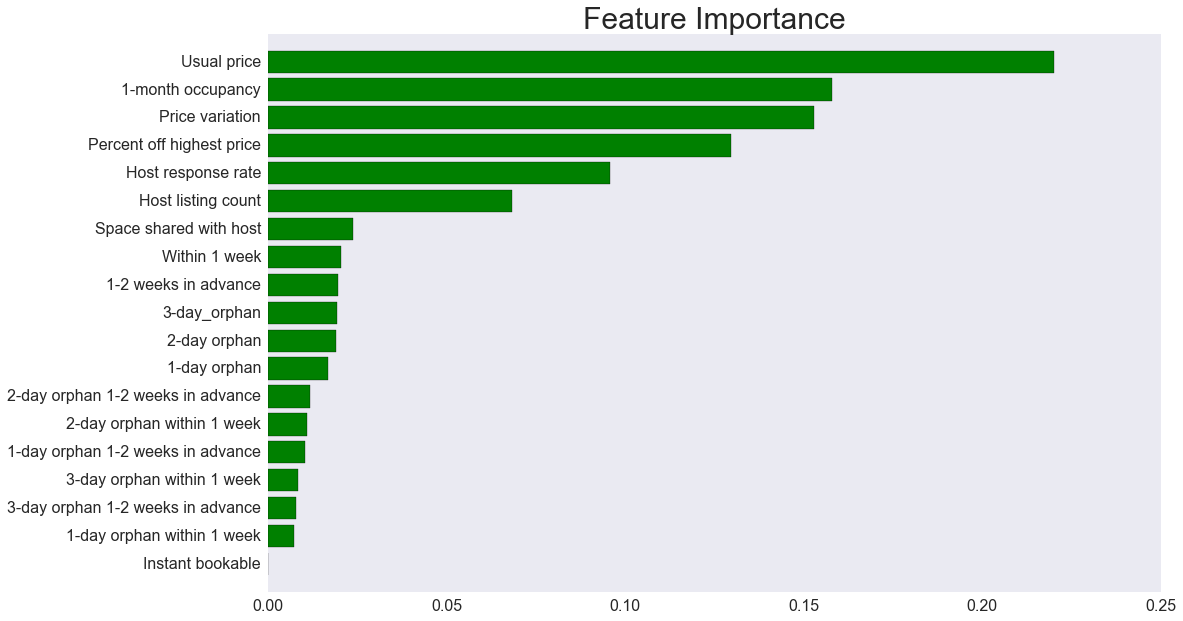

In [32]:
rf_all = RandomForestClassifier(n_estimators=1000, 
                            max_features=int(np.sqrt(X_willing_all_noda.shape[1])), 
                            max_depth=None,
                            min_samples_split=1)
model_fitting("rf", rf_all, X_willing_all_noda, Y_willing_all, label=param_label)

### Prediction

In [34]:
prediction_all_noda = rf_all.predict_proba(X_willing_all_noda)

In [36]:
print prediction_all_noda

[[ 0.882  0.118]
 [ 0.928  0.072]
 [ 0.907  0.093]
 ..., 
 [ 0.934  0.066]
 [ 0.887  0.113]
 [ 0.824  0.176]]


In [158]:
lr_all = LogisticRegression()
label_all = model_fitting("lr", lr_all, X_willing_all_noda, Y_willing_all)

Average Cross Validation Accuracy: 
0.786720321932
Cross Validation Accuracies by Fold: 
[ 0.78873239  0.78873239  0.78873239  0.78873239  0.78873239  0.78873239
  0.78873239  0.77464789  0.78571429  0.78571429]
Coefficients: 



In [41]:
svm_all = svm.SVC()
model_fitting("svm", svm_all, X_willing_all_noda, Y_willing_all)

Average Cross Validation Accuracy: 
0.790965794769
Cross Validation Accuracies by Fold: 
[ 0.78873239  0.8028169   0.76056338  0.78873239  0.81690141  0.78873239
  0.78873239  0.78873239  0.78571429  0.8       ]


In [43]:
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=None),
    RandomForestClassifier(max_depth=None, n_estimators=1000, max_features=5),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

print "Average Cross Validation Accuracy:"
for name, clf in zip(names, classifiers):
    clf.fit(X_willing_noda, Y_willing)
    cv_scores = -cross_val_score(clf, X_willing_all_noda, Y_willing_all, scoring='mean_squared_error', cv=10)

    print "%s: "%name, 1-np.mean(cv_scores)

### 3.3 Discount Obtained

Now, instead of classifiers, I used regressors for random forest, and linear regression instead of logistic.

Average Cross Validation Accuracy: 
0.989078360707
Cross Validation Accuracies by Fold: 
[ 0.99335897  0.9895792   0.99070962  0.98966017  0.98953599  0.98641354
  0.98720376  0.99150823  0.99143745  0.9813767 ]


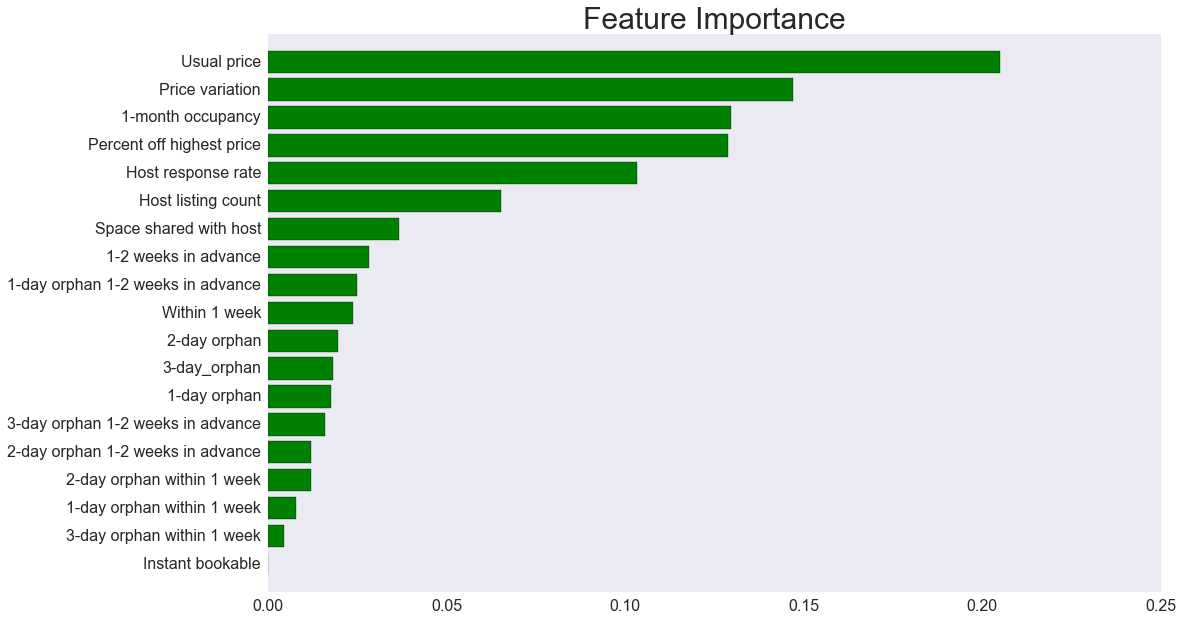

In [39]:
rf_discount = RandomForestRegressor(n_estimators=1000, 
                            max_features=int(np.sqrt(X_discount_noda.shape[1])), 
                            max_depth=None,
                            min_samples_split=1)
model_fitting("rf", rf_discount, X_discount_noda, Y_discount, label=param_label)

### RF Prediction

In [40]:
prediction_rf_discount = rf_discount.predict(X_discount_noda)

In [41]:
prediction_rf_discount

array([ 0.14939684,  0.1296054 ,  0.25769984,  0.12906442,  0.11501588,
        0.14974324,  0.21648512,  0.13126406,  0.18075144,  0.1213762 ,
        0.21408413,  0.19276148,  0.12228808,  0.09192057,  0.30026389,
        0.09480977,  0.20904564,  0.14757676,  0.12293031,  0.19249732,
        0.12221091,  0.14980282,  0.12775719,  0.20990666,  0.07891178,
        0.16982275,  0.20025222,  0.09512496,  0.20308813,  0.1971    ,
        0.25660388,  0.10389145,  0.21235392,  0.24484426,  0.17310458,
        0.25074932,  0.09035041,  0.19795771,  0.19208528,  0.09627746,
        0.20346191,  0.19644221,  0.20511438,  0.19801581,  0.14246145,
        0.25592523,  0.26849119,  0.17472709,  0.26048793,  0.23660067,
        0.25378941,  0.14041059,  0.3169547 ,  0.12343784,  0.26524546,
        0.17839151,  0.15185363,  0.10911971,  0.12121986,  0.14693635,
        0.13778641,  0.10983904,  0.14541444,  0.26789284,  0.26144269,
        0.12757025,  0.21345945,  0.09047057,  0.14111179,  0.16

In [161]:
lr_discount = LinearRegression()
lr_discount.fit(X_discount_noda, Y_discount)

lr_discount_scores = -cross_val_score(lr_discount, X_discount_noda, Y_discount, scoring='mean_squared_error', cv=10)
print "Average Cross Validation Accuracy: \n", 1-np.mean(lr_discount_scores)
print "Cross Validation Accuracies by Fold: \n", 1 - np.array(lr_discount_scores)
print "Coefficients: \n"

sign = ["(-)" if s<0 else "(+)" for s in np.sign(np.ravel(clf.coef_))]
label_discount = [x[0] + x[1] for x in zip(param_label_noda, sign)]

Average Cross Validation Accuracy: 
0.984941573391
Cross Validation Accuracies by Fold: 
[ 0.98977596  0.987797    0.97246924  0.98250821  0.99001684  0.98123999
  0.98597878  0.99017449  0.98727643  0.98217881]
Coefficients: 



In [148]:
lr_discount.predict(X_discount_noda)

array([ 0.19783081,  0.13095463,  0.2471574 ,  0.1789376 ,  0.17018553,
        0.19433957,  0.29514555,  0.17919247,  0.16480945,  0.15839812,
        0.15146601,  0.16159424,  0.16243784,  0.15750335,  0.18473816,
        0.15812256,  0.13087054,  0.15776836,  0.15180314,  0.22285515,
        0.2225996 ,  0.15956708,  0.16651866,  0.14141779,  0.15224587,
        0.13724983,  0.12783468,  0.2061625 ,  0.22912628,  0.1819324 ,
        0.21982342,  0.19520809,  0.16067879,  0.23910065,  0.18315374,
        0.2414067 ,  0.10355458,  0.14891011,  0.21766376,  0.12852787,
        0.15051861,  0.15013583,  0.17703905,  0.18895105,  0.15710597,
        0.16691157,  0.22515351,  0.18543086,  0.20311969,  0.19536473,
        0.14319243,  0.13820189,  0.20581424,  0.12680039,  0.19304993,
        0.18174871,  0.18264584,  0.14704357,  0.17225239,  0.20215673,
        0.09518621,  0.17738162,  0.18554979,  0.19295387,  0.24412544,
        0.16735348,  0.18380058,  0.13136943,  0.21279775,  0.16

In [149]:
Y_discount

array([ 0.11904762,  0.11111111,  0.32330827,  0.09677419,  0.1       ,
        0.12727273,  0.19678715,  0.10169492,  0.17808219,  0.09090909,
        0.25925926,  0.23566879,  0.09090909,  0.06382979,  0.36666667,
        0.05      ,  0.23913043,  0.125     ,  0.11111111,  0.20634921,
        0.1       ,  0.13333333,  0.09090909,  0.25373134,  0.03448276,
        0.18367347,  0.22222222,  0.05      ,  0.20849421,  0.20512821,
        0.31818182,  0.04545455,  0.25      ,  0.28994083,  0.18360656,
        0.3       ,  0.07692308,  0.22222222,  0.15254237,  0.05555556,
        0.25      ,  0.22222222,  0.2       ,  0.2020202 ,  0.12564767,
        0.3258427 ,  0.29090909,  0.15384615,  0.29139073,  0.27350427,
        0.31034483,  0.12121212,  0.4       ,  0.13333333,  0.30555556,
        0.16      ,  0.11144578,  0.05897114,  0.07692308,  0.11538462,
        0.13793103,  0.0625    ,  0.10714286,  0.31034483,  0.30177824,
        0.11764706,  0.2248062 ,  0.07142857,  0.11111111,  0.15

#### Variables against discounts given

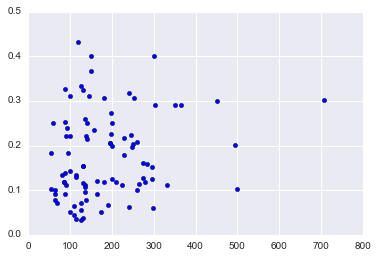

In [139]:
plt.scatter(combined_agreed["price_median"], combined_agreed["discount_obtained"])

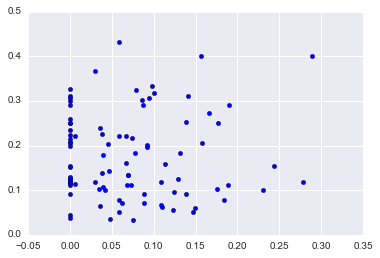

In [140]:
plt.scatter(combined_agreed["price_std"], combined_agreed["discount_obtained"])

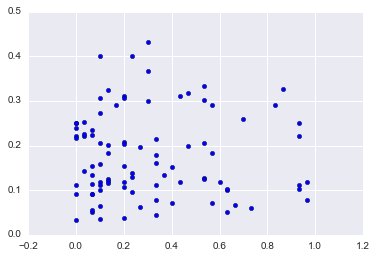

In [142]:
plt.scatter(combined_agreed["occupancy_1m"], combined_agreed["discount_obtained"])

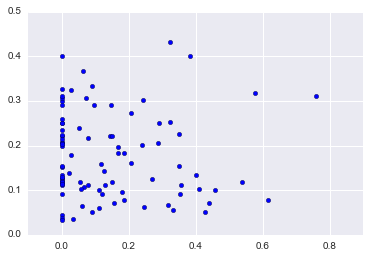

In [143]:
plt.scatter(combined_agreed["orig_percent_off"], combined_agreed["discount_obtained"])

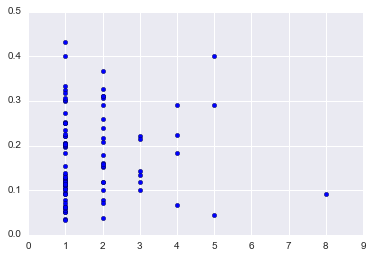

In [146]:
plt.scatter(combined_agreed["host_total_listings_count"], combined_agreed["discount_obtained"])

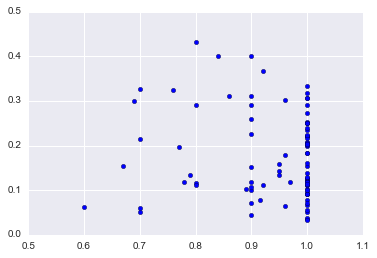

In [147]:
plt.scatter(combined_agreed["response_rate"], combined_agreed["discount_obtained"])

In [138]:
combined_agreed.head()

,host_total_listings_count,response_rate,instant,shared,price_median,price_std,occupancy_1m,orp_1,orp_2,orp_3,...,"orp_1, adv_2","orp_2, adv_1","orp_2, adv_2","orp_3, adv_1","orp_3, adv_2",orig_percent_off,discount_asked,decision,discount_obtained,source
195,1,0.90,False,False,210,0.000000,0.100000,0,0,1,...,0,0,0,1,0,0.000000,0.9,1,0.119048,2
200,1,0.92,False,True,90,0.188228,0.333333,0,0,0,...,0,0,0,0,0,0.357143,0.9,1,0.111111,2
202,1,0.76,False,False,130,0.078299,0.133333,0,0,0,...,0,0,0,0,0,0.029197,0.7,1,0.323308,2
203,1,1.00,False,False,135,0.124332,0.233333,0,0,1,...,0,0,0,0,1,0.179894,0.9,1,0.096774,2
204,3,0.90,False,True,65,0.041439,0.633333,0,0,0,...,0,0,0,0,0,0.111111,0.8,1,0.100000,2


In [ ]:
"orig_percent_off", "host_total_listings_count", "response_rate